<a href="https://colab.research.google.com/github/zeligism/ScaledVR/blob/main/Scaled_VR_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import sklearn
import scipy
import time
from numba import njit
from sklearn.preprocessing import normalize
SEED = 123
np.random.seed(SEED)

# Load data
data source: https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/

In [ ]:
!wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a1a

--2022-01-19 10:45:03--  https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a1a
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114818 (112K)
Saving to: ‘a1a.2’

a1a.2               100%[===================>] 112.13K   210KB/s    in 0.5s    

2022-01-19 10:45:04 (210 KB/s) - ‘a1a.2’ saved [114818/114818]



In [ ]:
!head a1a

-1 3:1 11:1 14:1 19:1 39:1 42:1 55:1 64:1 67:1 73:1 75:1 76:1 80:1 83:1 
-1 3:1 6:1 17:1 27:1 35:1 40:1 57:1 63:1 69:1 73:1 74:1 76:1 81:1 103:1 
-1 4:1 6:1 15:1 21:1 35:1 40:1 57:1 63:1 67:1 73:1 74:1 77:1 80:1 83:1 
-1 5:1 6:1 15:1 22:1 36:1 41:1 47:1 66:1 67:1 72:1 74:1 76:1 80:1 83:1 
-1 2:1 6:1 16:1 22:1 36:1 40:1 54:1 63:1 67:1 73:1 75:1 76:1 80:1 83:1 
-1 2:1 6:1 14:1 20:1 37:1 41:1 47:1 64:1 67:1 73:1 74:1 76:1 82:1 83:1 
-1 1:1 6:1 14:1 22:1 36:1 42:1 49:1 64:1 67:1 72:1 74:1 77:1 80:1 83:1 
-1 1:1 6:1 17:1 19:1 39:1 42:1 53:1 64:1 67:1 73:1 74:1 76:1 80:1 83:1 
-1 2:1 6:1 18:1 20:1 37:1 42:1 48:1 64:1 71:1 73:1 74:1 76:1 81:1 83:1 
+1 5:1 11:1 15:1 32:1 39:1 40:1 52:1 63:1 67:1 73:1 74:1 76:1 78:1 83:1 


In [ ]:
# see  https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_svmlight_file.html
from joblib import Memory
from sklearn.datasets import load_svmlight_file
mem = Memory("./mycache")

@mem.cache
def get_data(filePath):
    data = load_svmlight_file(filePath)
    return data[0], data[1]

X, y = get_data("a1a")
n, d =X.shape
X = normalize(X, norm='l2', axis=1)
print("We have %d samples, each has up to %d features"%(n,d))

We have 1605 samples, each has up to 119 features


# Logistic Loss
$n=$ number of data points

$d=$ feature dimension

$X \in \mathbb{R}^{n \times d}$, $x_i = X[i,:] \in \mathbb{R}^{d}$, $y \in \mathbb{R}^{n}$, and $w \in \mathbb{R}^{d}$.

Then,

$
F(w) = \frac1n \sum_{i=1}^n \log(1+e^{-y_i x_i^T w})
$

$
\nabla F(w) = \frac1n \sum_{i=1}^n 
\frac{\exp(-y_i x_i^T w)}{(1+\exp(-y_i x_i^T w))} (-y_i x_i)
$

$
\nabla^2 F(w) = \frac1n \sum_{i=1}^n 
\left(
  \frac{\exp(-y_i x_i^T w)}
       {(1+\exp(-y_i x_i^T w))^2}
\right) (  x_i x_i^T )
$

In [ ]:
@njit
def logistic_loss_jit(X,y,w):
  ...

@njit
def logistic_loss_grad_jit(X,y,w):
  ...

def logistic_loss(X,y,w):
  r = np.exp(-y * (X @ w))
  loss = np.mean(np.log(1 + r))
  return loss

def logistic_loss_grad(X,y,w):
  r = np.exp(-y * (X @ w))
  grad = X.T.dot(-y * r/(1+r)) / X.shape[0]
  return grad

def logistic_loss_hessian(X,y,w):
  r = np.exp(-y * (X @ w))
  rh = r / (1+r)**2
  hessian = X.T.dot(rh.reshape(-1,1) * X) / X.shape[0]
  return hessian

def F(X, y, w, i=None):
  if i is not None:
    if isinstance(i, int):
      i = [i]
    y = y[i]
    X = X[i,:]
  return logistic_loss(X,y,w)

def grad(X, y, w, i=None):
  if i is not None:
    if isinstance(i, int):
      i = [i]
    y = y[i]
    X = X[i,:]
  return logistic_loss_grad(X,y,w)

def hessian(X, y, w, i=None):
  if i is not None:
    if isinstance(i, int):
      i = [i]
    y = y[i]
    X = X[i,:]
  X = np.array(X.todense()) # for element-wise prod
  return logistic_loss_hessian(X,y,w)

In [ ]:
def test_logistic(X,y):
  import torch
  # np
  i = np.random.choice(X.shape[0], 10)
  w = np.random.randn(X.shape[1])
  X = X[i]
  y = y[i]
  L = F(X,y,w)
  G = grad(X,y,w)
  H = hessian(X,y,w)
  # torch
  def F_torch(w):
    return torch.mean(torch.log(1 + torch.exp(-y * (X @ w))))
  w = torch.Tensor(w).requires_grad_()
  X = torch.Tensor(X.todense()).requires_grad_()
  y = torch.Tensor(y)
  L_torch = F_torch(w)
  G_torch, = torch.autograd.grad(L_torch, w)
  H_torch = torch.autograd.functional.hessian(F_torch, w)
  # check
  assert np.abs(L.sum() - L_torch.sum().item()) < 0.0001
  assert np.abs(G.sum() - G_torch.sum().item()) < 0.0001
  assert np.abs(H.sum() - H_torch.sum().item()) < 0.0001

test_logistic(X,y)
print("Success!")

Success!


# Plot

In [ ]:
def plot_data(data):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  fig.set_size_inches(20, 6)
  
  ax1.plot(data[:,0])
  ax1.set_ylabel(r"$F(w_t)$")
  ax1.set_xlabel(r"iteration $t$")  
  
  ax2.semilogy(data[:,1])
  ax2.set_ylabel(r"$||\nabla F(w_t)||^2$")
  ax2.set_xlabel(r"iteration $t$") 
  
  ax3.plot(data[:,2])
  ax3.set_ylabel(r"error")
  ax3.set_xlabel(r"iteration $t$") 

# SGD

In [ ]:
def SGD(X, y, gamma=0.01, BS=1, T=10000):
  data = []
  #w = np.random.randn(X.shape[1])  # initalize w randomly
  w = np.zeros(X.shape[1])
  for it in range(T):
    i = np.random.choice(X.shape[0], BS)
    w = w - gamma * grad(X,y,w,i)
    data.append((F(X,y,w),
                  np.linalg.norm(grad(X,y,w))**2,
                  np.mean(X.dot(w)*y < 0)))
  return w, np.array(data)

CPU times: user 7.29 s, sys: 34.6 ms, total: 7.33 s
Wall time: 7.34 s


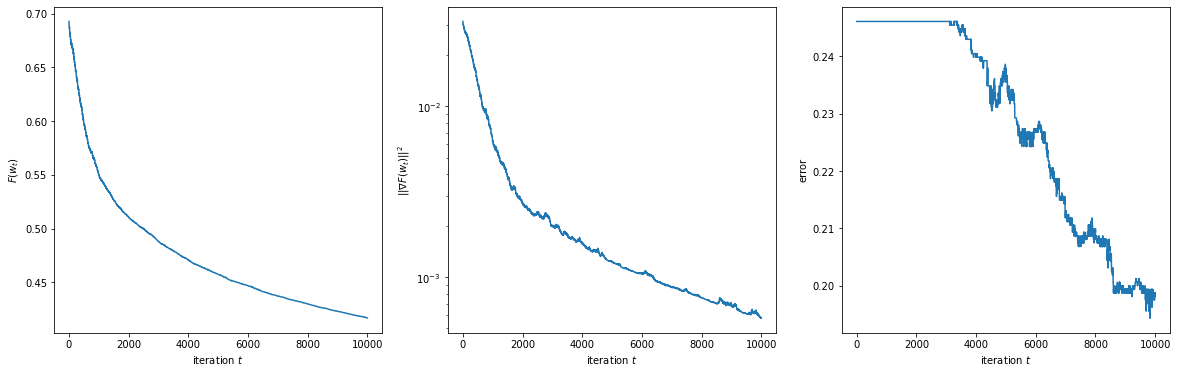

In [ ]:
%%time
_, data = SGD(X,y)
plot_data(data)

using a bigger batch size
CPU times: user 7.28 s, sys: 29.4 ms, total: 7.31 s
Wall time: 7.35 s


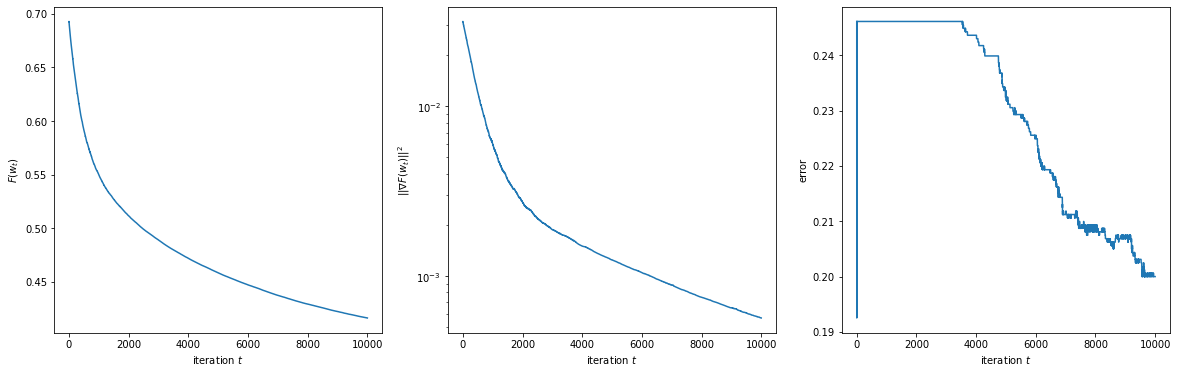

In [ ]:
%%time
print("using a bigger batch size")
_, data = SGD(X,y,BS=10)
plot_data(data)

## Use bad scaling and run SGD again

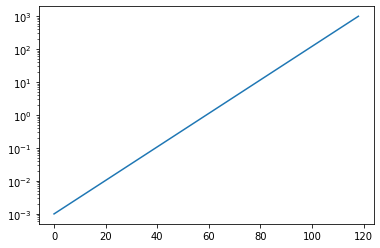

In [ ]:
BAD_SCALE = 10**np.linspace(-3,3,X.shape[1])
#BAD_SCALE = 10**np.linspace(-3,5,X.shape[1])**3
plt.semilogy(BAD_SCALE)

def corrupt_scale(X, bad_scale=BAD_SCALE):
  np.random.shuffle(bad_scale)
  X_bad = X+0.0
  X_bad = X.multiply(bad_scale.reshape(1,-1)).tocsr()
  # X_bad = normalize(X_bad, norm='l2', axis=1)
  return X_bad

np.random.seed(SEED+1)
X_bad = corrupt_scale(X)

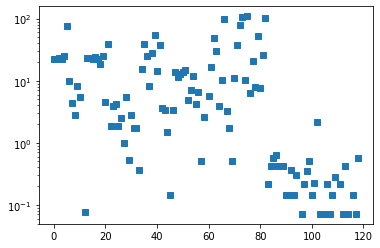

In [ ]:
plt.semilogy([np.linalg.norm(X[:,j].data)**2 for j in range(d)],'s')

use uneven scaling of features
CPU times: user 7.35 s, sys: 30.1 ms, total: 7.38 s
Wall time: 7.39 s


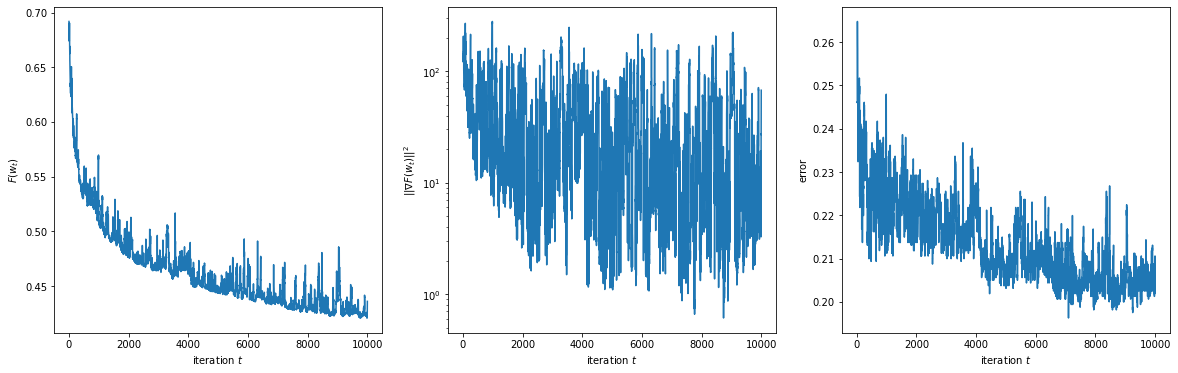

In [ ]:
%%time
print("use uneven scaling of features")
_, data = SGD(X_bad,y,BS=1,gamma=1e-5)
plot_data(data)

try with a bigger batch size
CPU times: user 7.31 s, sys: 25.8 ms, total: 7.34 s
Wall time: 7.35 s


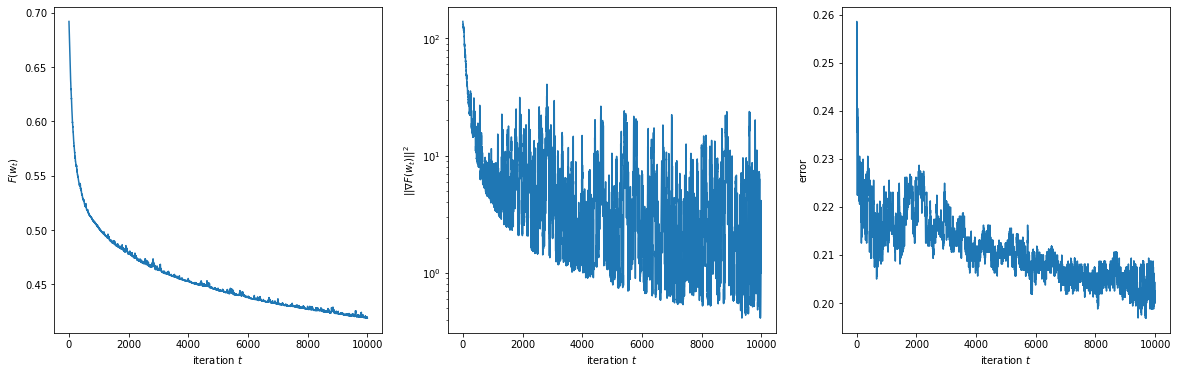

In [ ]:
%%time
print("try with a bigger batch size")
_, data = SGD(X_bad,y,BS=10,gamma=1e-5)
plot_data(data)

# SARAH

In [ ]:
def SARAH(X, y, gamma=0.1, BS=1, epochs=10):
  data = []
  #wn = np.random.randn(X.shape[1])  # initalize w randomly
  wn = np.zeros(X.shape[1])
  for ep in range(epochs):
    v = grad(X,y,wn)
    nv0 = np.linalg.norm(v)
    wp = wn[:]
    #wn = wp - gamma*v
    for it in range(10**10):
      i = np.random.choice(X.shape[0], BS)
      gn = grad(X,y,wn,i)
      gp = grad(X,y,wp,i)
      v += gn - gp
      wp = wn[:]
      wn = wn - gamma * v
      data.append((F(X,y,wn),
                   np.linalg.norm(grad(X,y,wn))**2,
                   np.mean(X.dot(wn)*y < 0)))
      nv = np.linalg.norm(v)
      if nv < 0.1*nv0 or it > X.shape[0]:
        break
        
  return wn, np.array(data)

CPU times: user 15.3 s, sys: 53.6 ms, total: 15.4 s
Wall time: 15.4 s


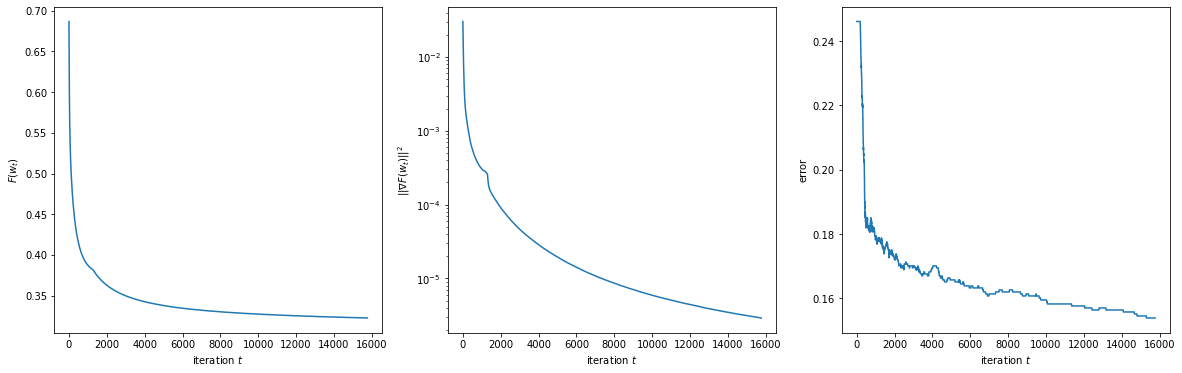

In [ ]:
%%time
_, data = SARAH(X,y,gamma=0.2)
plot_data(data)

with a bigger batch size
CPU times: user 15 s, sys: 51.8 ms, total: 15.1 s
Wall time: 15.1 s


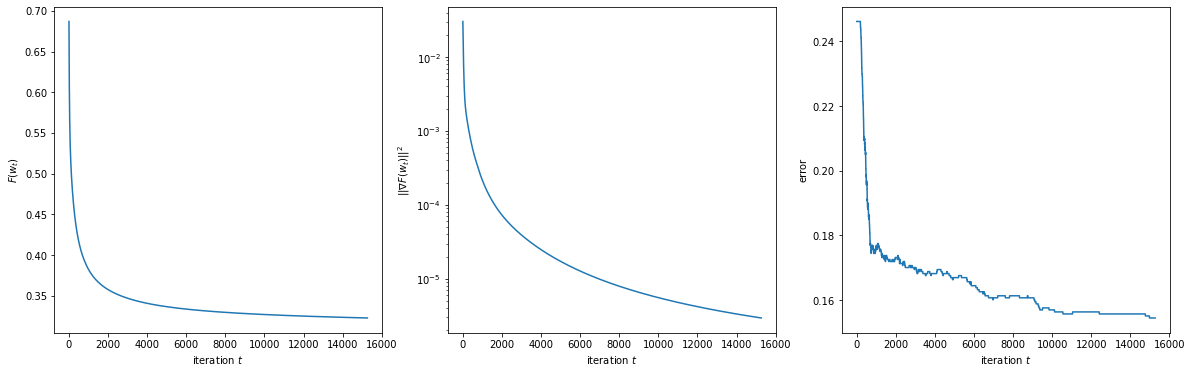

In [ ]:
%%time
print("with a bigger batch size")
_, data = SARAH(X,y,BS=10,gamma=0.2)
plot_data(data)

## Use bad scaling and run SARAH again

In [ ]:
# np.random.seed(SEED+1)
# X_bad = corrupt_scale(X)

use uneven scaling of features
CPU times: user 31.4 s, sys: 137 ms, total: 31.5 s
Wall time: 31.5 s


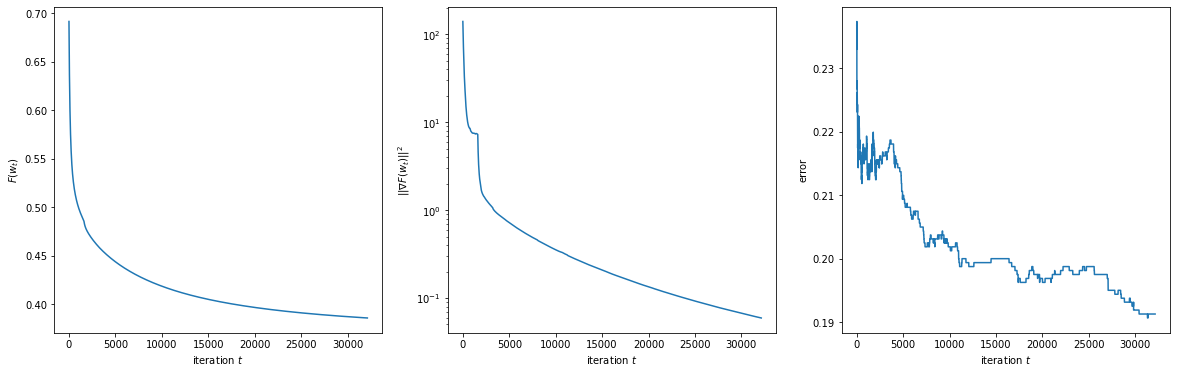

In [ ]:
%%time
print("use uneven scaling of features")
_, data = SARAH(X_bad,y,gamma=1e-5,epochs=20)
plot_data(data)

with a bigger batch size
CPU times: user 31.4 s, sys: 98.1 ms, total: 31.5 s
Wall time: 31.5 s


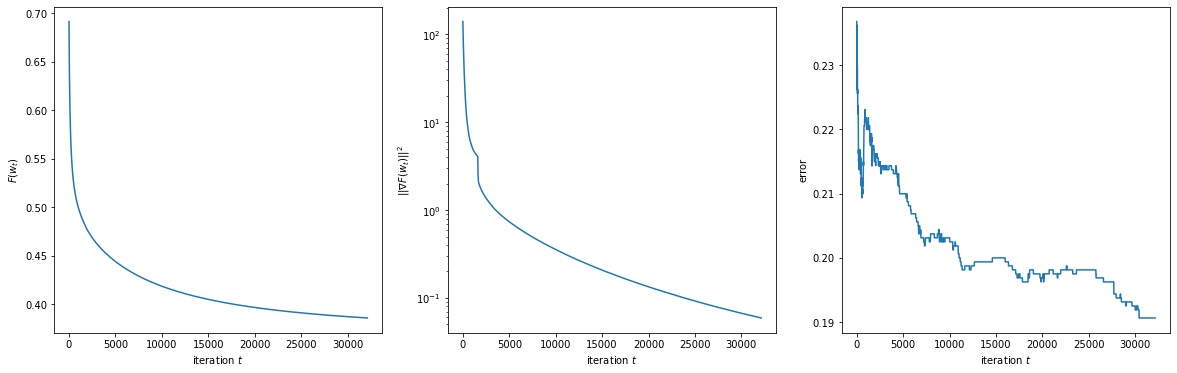

In [ ]:
%%time
print("with a bigger batch size")
_, data = SARAH(X_bad,y,BS=10,gamma=1e-5,epochs=20)
plot_data(data)

# Hessian scaling

## First, check approximation of Hessian diagonal

In [ ]:
w = np.random.randn(X.shape[1])
H = hessian(X,y,w)
diag_H = np.diagonal(H)

0.21578223395449897
0.19825448573412693


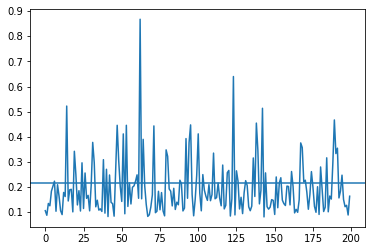

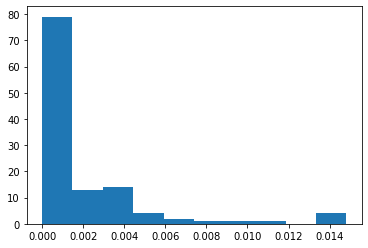

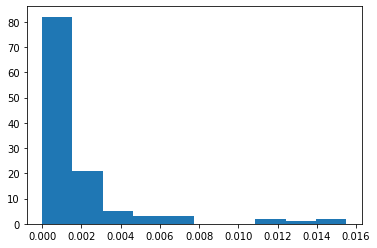

In [ ]:
# grad(w+z)-grad(w) approx= H(w)z
def sample_z():
  return 2*np.random.randint(0,2,(diag_H.shape[0]))-1

num_samples = 200
diag_H_approx = 0.
diag_H_sums = []
for _ in range(num_samples):
  z = sample_z()
  diag_H_i = z * (grad(X,y,w+z) - grad(X,y,w))
  diag_H_approx += diag_H_i / num_samples
  diag_H_sums.append(diag_H_i.sum())

plt.figure()
plt.plot(np.array(diag_H_sums))
plt.axhline(diag_H.sum())

plt.figure()
plt.hist(diag_H)
print(diag_H.sum())

plt.figure()
plt.hist(diag_H_approx)
print(diag_H_approx.sum())

## Run SARAH on badly-scaled data given the $diag(H)$ approximation

In [ ]:
XTX = np.array((X.T @ X).todense())
XTX_bad = np.array((X_bad.T @ X_bad).todense())

PLotting eigenvalues of X and X_bad


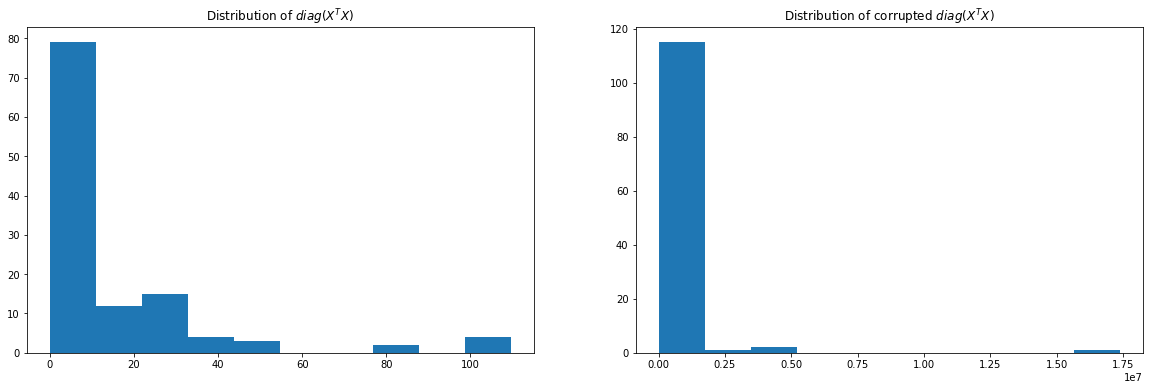

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 6)
ax1.set_title(r"Distribution of $diag(X^TX)$")
ax1.hist(np.diagonal(XTX))
ax2.set_title(r"Distribution of corrupted $diag(X^TX)$")
ax2.hist(np.diagonal(XTX_bad))
print("PLotting eigenvalues of X and X_bad")

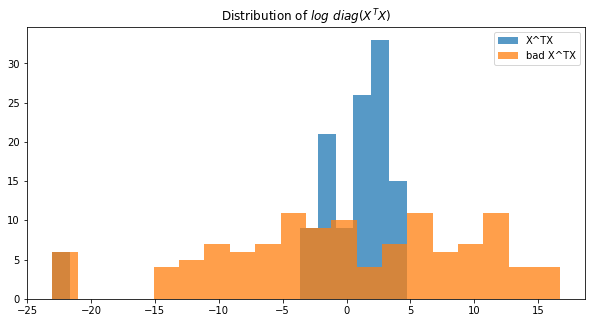

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.title(r"Distribution of $log\ diag(X^TX)$")
#plt.hist(np.diagonal(XTX_bad), label="bad X^TX")
#plt.hist(np.diagonal(XTX), label="X^TX")
plt.hist(np.log(np.diagonal(1e-10+XTX)), label="X^TX", bins=20, alpha=0.75)
plt.hist(np.log(np.diagonal(1e-10+XTX_bad)), label="bad X^TX", bins=20, alpha=0.75)
plt.legend()

### SGD

SGD on normal data with default settings
CPU times: user 7.18 s, sys: 11.9 ms, total: 7.19 s
Wall time: 7.17 s


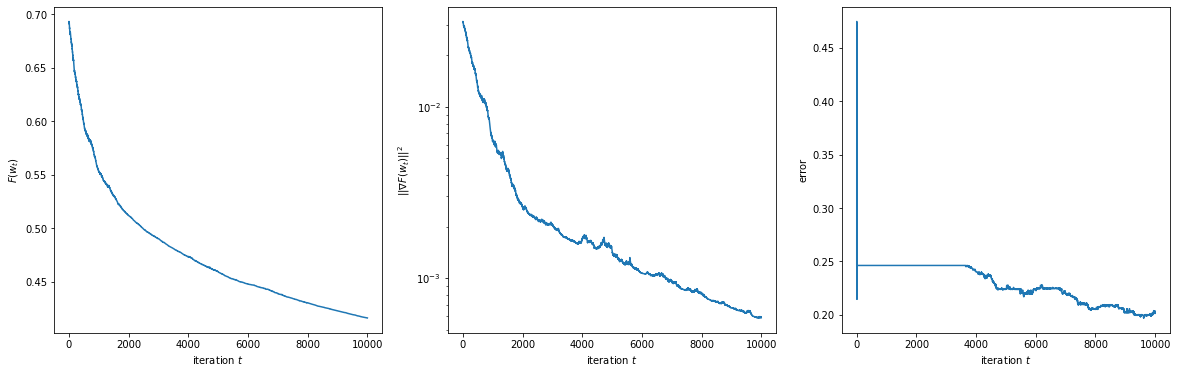

In [ ]:
%%time
print("SGD on normal data with default settings")
_, data = SGD(X,y,gamma=0.01)
plot_data(data)

SGD on corrupted data with default settings


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


CPU times: user 6.67 s, sys: 14.9 ms, total: 6.68 s
Wall time: 6.69 s


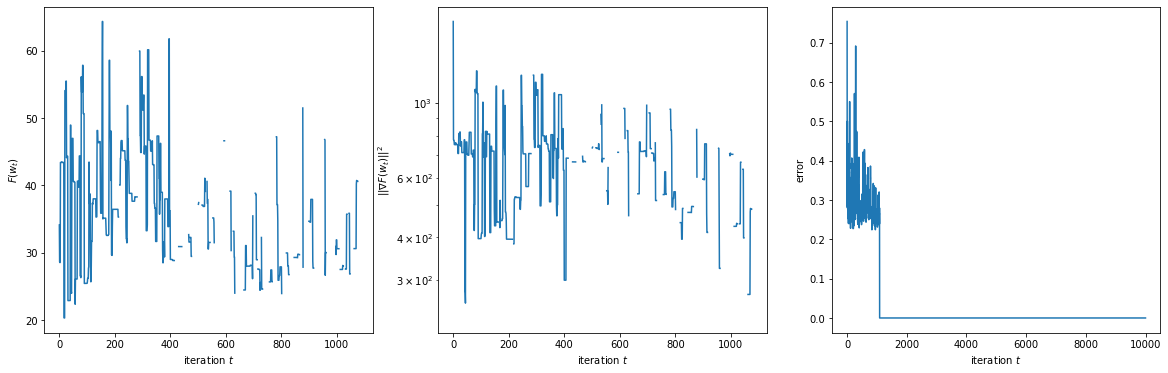

In [ ]:
%%time
print("SGD on corrupted data with default settings")
_, data = SGD(X_bad,y,gamma=0.01)
plot_data(data)

SGD on corrupted data with diag(X_bad^TX_bad)^-1 scaling
CPU times: user 7.06 s, sys: 19.9 ms, total: 7.08 s
Wall time: 7.06 s


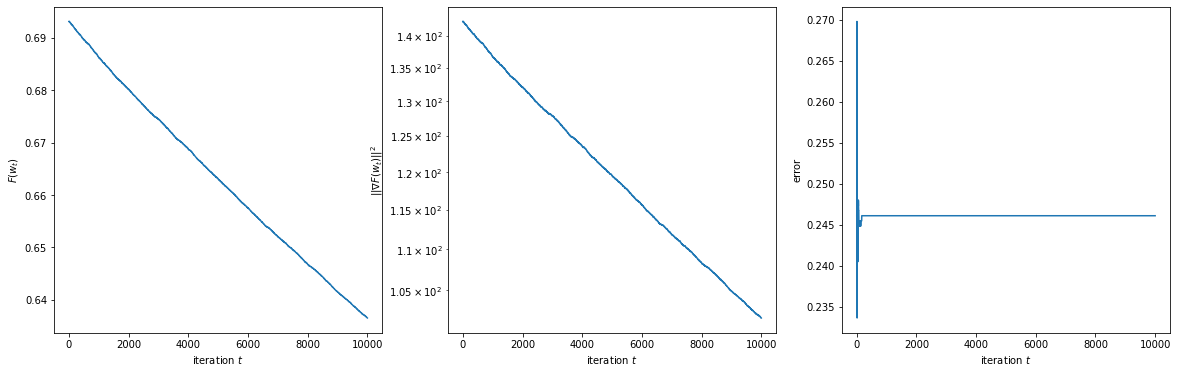

In [ ]:
%%time
print("SGD on corrupted data with diag(X_bad^TX_bad)^-1 scaling")
_, data = SGD(X_bad,y,gamma=0.01*np.diagonal(XTX_bad+1e-10)**-1)
plot_data(data)

SGD on corrupted data with diag(H)^-1 scaling


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


CPU times: user 6.54 s, sys: 17 ms, total: 6.56 s
Wall time: 6.57 s


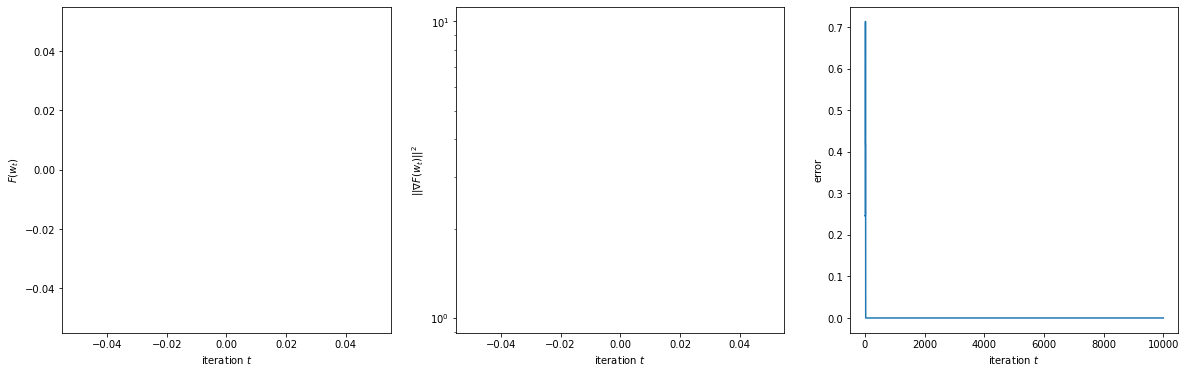

In [ ]:
%%time
print("SGD on corrupted data with diag(H)^-1 scaling")
_, data = SGD(X_bad,y,gamma=0.01*(diag_H+1e-10)**-1)
plot_data(data)

### SARAH

SARAH on normal data with default settings
CPU times: user 15.4 s, sys: 41.1 ms, total: 15.5 s
Wall time: 15.4 s


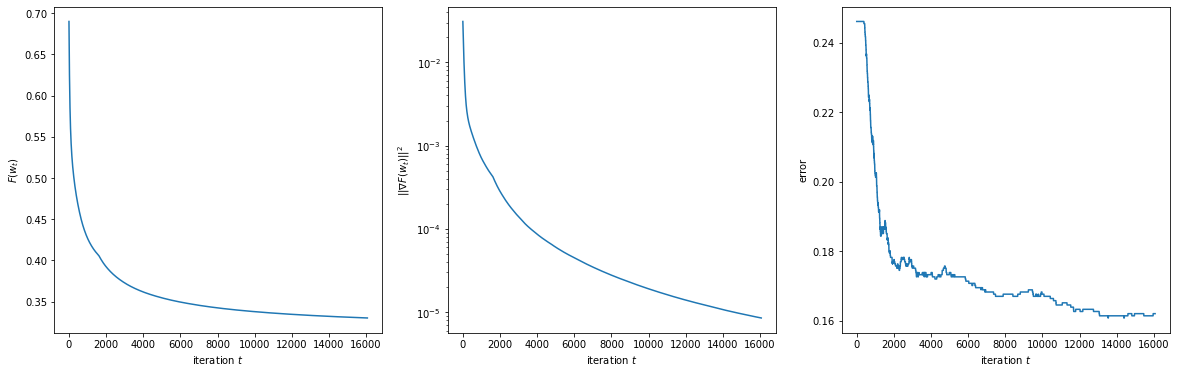

In [ ]:
%%time
print("SARAH on normal data with default settings")
_, data = SARAH(X,y,gamma=0.1)
plot_data(data)

SARAH on corrupted data with default settings


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


CPU times: user 28.8 s, sys: 60.9 ms, total: 28.9 s
Wall time: 28.9 s


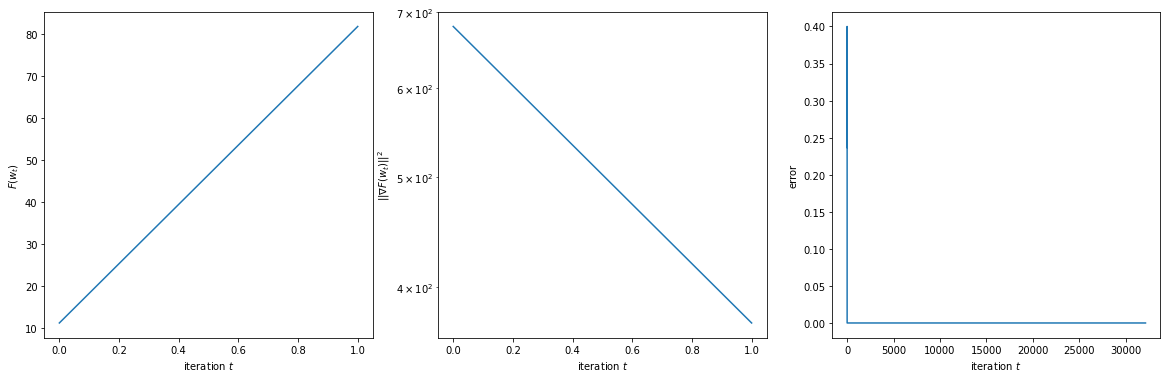

In [41]:
%%time
print("SARAH on corrupted data with default settings")
_, data = SARAH(X_bad,y,gamma=0.1,epochs=20)
plot_data(data)

SARAH on corrupted data with diag(X_bad^TX_bad)^-1 scaling
CPU times: user 15.2 s, sys: 24.8 ms, total: 15.3 s
Wall time: 15.3 s


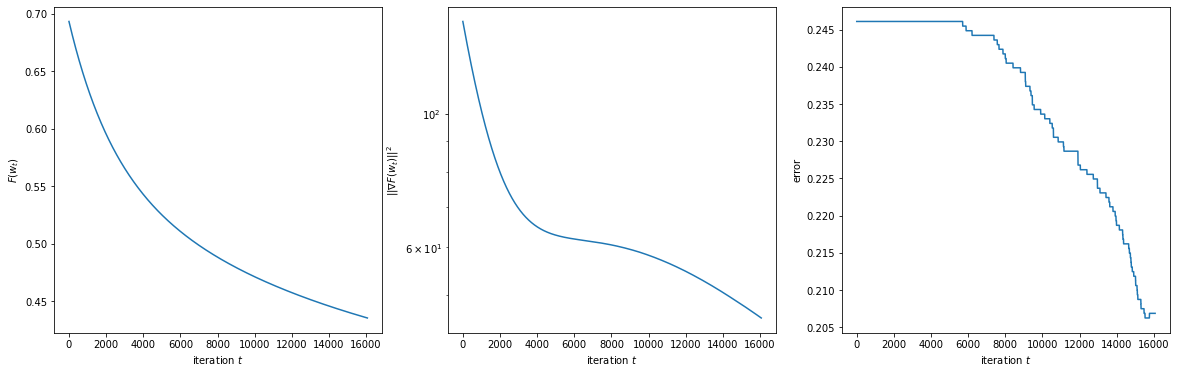

In [42]:
%%time
print("SARAH on corrupted data with diag(X_bad^TX_bad)^-1 scaling")
_, data = SARAH(X_bad,y,gamma=0.1*np.diagonal(XTX_bad+1e-10)**-1)
plot_data(data)

SARAH on corrupted data with diag(H)^-1 scaling


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


CPU times: user 14.5 s, sys: 41.9 ms, total: 14.5 s
Wall time: 14.5 s


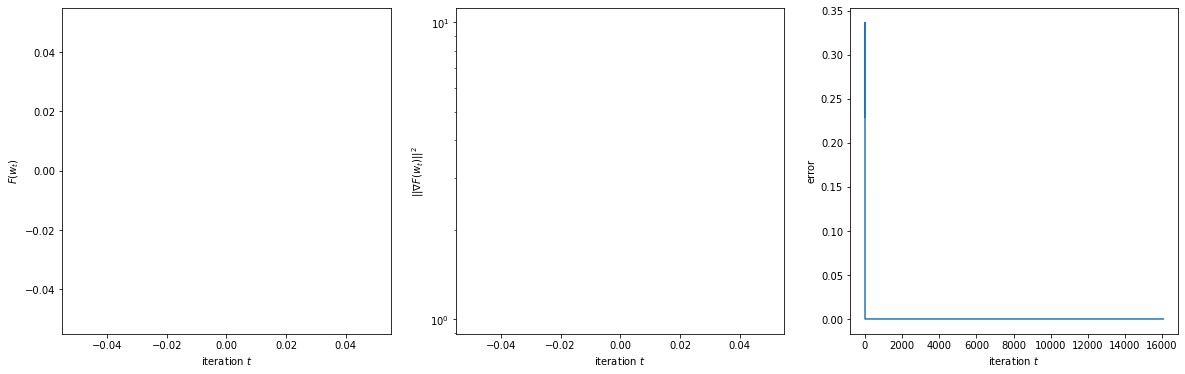

In [44]:
%%time
print("SARAH on corrupted data with diag(H)^-1 scaling")
_, data = SARAH(X_bad,y,gamma=0.1*(diag_H+1e-10)**-1)
plot_data(data)